# **NLP Challenge**

I will perform Sentiment Analysis on the IMDB Movie reviews Dataset and predict whether a review is Positive or Negative.

# Pre-Processing of the Data

### Importing the required Libraries 
We import the libraries required for pre processing of the Data



In [1]:
import pandas as pd
import random
import re
import string
from bs4 import BeautifulSoup
import csv
import numpy as np

Below Libraries are for NLP purposes.

In [2]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Reading the dataset

In [3]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

### Cleaning the text

We will now clean the text and get rid of the HTML tags that are present in the sentences by using BeautifulSoup.


In [5]:
def clean(review):
    # review without HTML tags
    review = BeautifulSoup(review).get_text()
    # review without punctuation and numbers
    review = re.sub("[^a-zA-Z]",' ',review)
    # converting into lowercase and splitting to eliminate stopwords
    review = review.lower()
    return review

We'll now remove the stopwords from the reviews. Stopwords are the words that don't contribute to our analysis.

In [6]:
def remove_stopwords(review):
  # use set for faster stopword detection
  stop_words = set(stopwords.words("english"))
  # if word is not in the set of stopwords, store it in a list
  review = [word for word in review.split() if word not in stop_words]
  # join the words in the list and return the sentence formed
  return (" ".join(review))

In [7]:
df["review"]= df["review"].apply(clean)
df["review"]= df["review"].apply(remove_stopwords)

Now, we'll change the labels from positive and negative to 1 and 0 respectively.

In [8]:
def change_label(x):
  if x=='positive':
    return 1
  else:
    return 0
df['sentiment'] = df['sentiment'].apply(change_label)

In [9]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


# Splitting the Dataset

We'll now split the dataset into training and testing sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df["review"], df["sentiment"],test_size=.2)
len(X_train)

40000

# Plotting the Graph

We'll define a function to plot the graphs. We'll use this function to plot the accuracy and loss graphs.

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Padding and Tokenizing

We will now tokenize and pad the reviews using tensorflow so that they could be used in the models


In [13]:
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = ""

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)

In [15]:
padded = np.array(padded)
sentiment_labels_training = np.array(Y_train)
testing_padded = np.array(testing_padded)
sentiment_labels_final = np.array(Y_test)

# Building the Flatten Model

In [16]:
import tensorflow as tf

In [17]:
embedding_dim = 500

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# We use binary_crossentropy as our loss function and "adam" optimizer to minimize our loss function.

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 500)          5000000   
                                                                 
 flatten (Flatten)           (None, 60000)             0         
                                                                 
 dense (Dense)               (None, 6)                 360006    
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 5,360,013
Trainable params: 5,360,013
Non-trainable params: 0
_________________________________________________________________


In [18]:
history=model.fit(padded, sentiment_labels_training, epochs=10, validation_data=(testing_padded, sentiment_labels_final))

Epoch 1/10
1250/1250 [==============================] - 62s 46ms/step - loss: 0.3947 - accuracy: 0.8020 - val_loss: 0.2994 - val_accuracy: 0.8742
Epoch 2/10
1250/1250 [==============================] - 13s 11ms/step - loss: 0.0910 - accuracy: 0.9689 - val_loss: 0.4177 - val_accuracy: 0.8526
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.5982 - val_accuracy: 0.8575
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 7.4980e-04 - accuracy: 0.9999 - val_loss: 0.6686 - val_accuracy: 0.8576
Epoch 5/10
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1707e-04 - accuracy: 1.0000 - val_loss: 0.7075 - val_accuracy: 0.8588
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 4.5787e-05 - accuracy: 1.0000 - val_loss: 0.7435 - val_accuracy: 0.8596
Epoch 7/10
1250/1250 [==============================] - 8s 7ms/step - loss: 2.2937e-05 - accuracy: 1.0000 - val_loss: 0.

This model gave training accuracy of 100% and validation accuracy of 86% which means that the model is overfitting, so we'll use another model for sentiment analysis. 

Let's plot the graph of Accuracy and the loss function for this model.

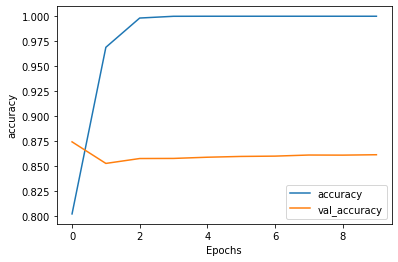

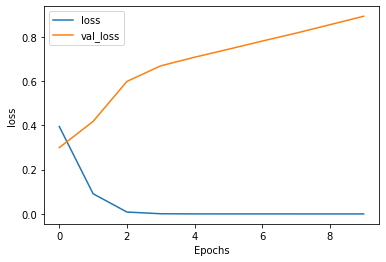

In [19]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Building the LSTM Model

We'll use a LSTM(Long Short Term Memory) Model now to perform sentiment analysis.

In [20]:
from tensorflow import keras

In [21]:
#Build the Model
model_2 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.SpatialDropout1D(0.25),
    keras.layers.LSTM(50, dropout=0.55, recurrent_dropout=0.55),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

# We use binary_crossentropy as our loss function and "adam" optimizer to minimize our loss function.
model_2.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 500)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 500)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                110200    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,110,251
Trainable params: 5,110,251
Non-trainable params: 0
____________________________________________

In [22]:
history_2 = model_2.fit(padded, sentiment_labels_training, epochs = 5, validation_data=(testing_padded, sentiment_labels_final))

Epoch 1/5
1250/1250 [==============================] - 336s 267ms/step - loss: 0.3781 - accuracy: 0.8364 - val_loss: 0.3076 - val_accuracy: 0.8743
Epoch 2/5
1250/1250 [==============================] - 301s 241ms/step - loss: 0.2648 - accuracy: 0.8967 - val_loss: 0.3587 - val_accuracy: 0.8744
Epoch 3/5
1250/1250 [==============================] - 297s 238ms/step - loss: 0.2097 - accuracy: 0.9191 - val_loss: 0.3761 - val_accuracy: 0.8644
Epoch 4/5
1250/1250 [==============================] - 307s 246ms/step - loss: 0.1703 - accuracy: 0.9354 - val_loss: 0.3598 - val_accuracy: 0.8709
Epoch 5/5
1250/1250 [==============================] - 296s 237ms/step - loss: 0.1397 - accuracy: 0.9498 - val_loss: 0.4126 - val_accuracy: 0.8638


Let's plot the graph for accuracy and loss for the LSTM Model.

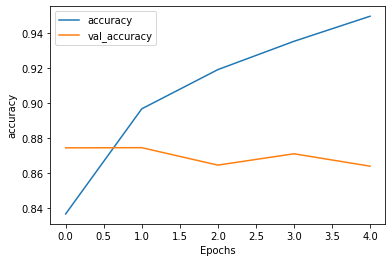

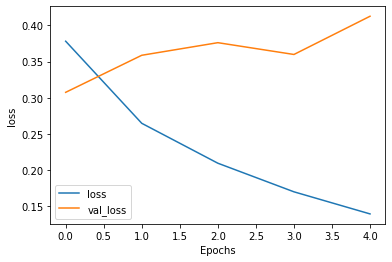

In [23]:
plot_graphs(history_2, 'accuracy')
plot_graphs(history_2, 'loss')

This model gives training accuracy of 94% and test accuracy of 86%. So this is a better model than the Flatten model.